# 循环神经网络的简洁实现
:label:`sec_rnn-concise`

虽然 :numref:`sec_rnn_scratch` 对了解循环神经网络是如何实现的很有指导意义，但这并不便捷。本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。我们从读取时光机器数据集开始。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 定义模型

高级API提供了循环神经网络的实现。我们构造了一个具有256隐藏单元的单隐藏层的循环神经网络层 `rnn_layer`。事实上，我们还没有讨论多层的含义——这将在 :numref:`sec_deep_rnn`介绍。现在，只要说多层仅仅相当于一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。


In [2]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

我们使用张量来初始化隐藏状态，它的形状是(隐藏层数, 批量大小, 隐藏单元数)。


In [3]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

通过一个隐藏状态和一个输入，我们可以用更新后的隐藏状态计算输出。需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算：它是指每个时间步的隐藏状态，它们可以用作后续输出层的输入。


In [4]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

与 :numref:`sec_rnn_scratch` 类似，我们为一个完整的循环神经网络模型定义了一个 `RNNModel` 类。注意 `rnn_layer` 只包含隐藏循环层，我们需要创建一个单独的输出层。


In [5]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），`num_directions`应该是2，否则应该是1。
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将`Y`的形状改为(`时间步数` * `批量大小`, `隐藏单元数`)。
        # 它的输出形状是 (`时间步数` * `批量大小`, `词表大小`)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` 以张量作为隐藏状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            # `nn.LSTM` 以张量作为隐藏状态
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

## 训练与预测

在训练模型之前，让我们用一个具有随机权重的模型进行预测。


In [6]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerttntntntnt'

很明显，这种模型根本不起作用。接下来，我们使用 :numref:`sec_rnn_scratch` 中定义的超参数调用 `train_ch8`，并使用高级API训练模型。


perplexity 1.3, 302270.3 tokens/sec on cuda:0
time traveller hat ona aravilbed to ou syount gentans caspang ha
traveller buth thickness vit t authed that sher a ovest oul


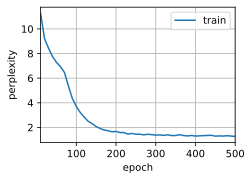

In [7]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

与上一节相比，由于深度学习框架的高级API对代码进行了更多的优化，该模型在较短的时间内实现了类似的困惑度。

## 小结

* 深度学习框架的高级API提供了循环神经网络层的实现。
* 高级API的循环神经网络层返回输出和更新的隐藏状态，其中输出不涉及输出层计算。
* 与从零开始实现相比，使用高级API会使循环神经网络训练的更快。

## 练习

1. 你能使用高级API使循环神经网络模型过拟合吗？
1. 如果在循环神经网络模型中增加隐藏层的数量会发生什么？你能使模型工作吗？
1. 使用循环神经网络实现 :numref:`sec_sequence` 的自回归模型。


[Discussions](https://discuss.d2l.ai/t/2106)
